In [ ]:
!git clone https://github.com/niloydebbarma-code/Deepfakes-detection.git
%cd Deepfakes-detection

Cloning into 'Deepfakes-detection'...
remote: Enumerating objects: 1112, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1112 (delta 0), reused 9 (delta 0), pack-reused 1103 (from 1)
Receiving objects: 100% (1112/1112), 158.43 MiB | 54.44 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (1356/1356), done.
/content/Deepfakes-detection


In [ ]:
import os

# Base directory path
base_dir = '/content/Deepfakes-detection/DeepfakeTIMIT'

# Dictionary to store file paths categorized by file type
files_by_type = {
    'png': [],
    'mov': [],
    'dircksum': [],
    'wav': [],
    'avi': []
}

# Function to categorize and store files
def categorize_files(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Extract file extension
            file_ext = file.split('.')[-1].lower()
            # Categorize files based on their extension
            if file_ext == 'png':
                files_by_type['png'].append(file_path)
            elif file_ext == 'mov':
                files_by_type['mov'].append(file_path)
            elif file_ext == 'dircksum':
                files_by_type['dircksum'].append(file_path)
            elif file_ext == 'wav':
                files_by_type['wav'].append(file_path)
            elif file_ext == 'avi':
                files_by_type['avi'].append(file_path)

# Call the function to categorize files
categorize_files(base_dir)

# Print the categorized files
for file_type, paths in files_by_type.items():
    print(f"\nFound {len(paths)} {file_type} files:")
    for path in paths:
        print(path)


Found 2 png files:
/content/Deepfakes-detection/DeepfakeTIMIT/deepfake_images_2.png
/content/Deepfakes-detection/DeepfakeTIMIT/deepfake_images_1.png

Found 3 mov files:
/content/Deepfakes-detection/DeepfakeTIMIT/fadg0-original.mov
/content/Deepfakes-detection/DeepfakeTIMIT/fram1-original.mov
/content/Deepfakes-detection/DeepfakeTIMIT/fadg0-fram1-roi93.mov

Found 67 dircksum files:
/content/Deepfakes-detection/DeepfakeTIMIT/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fjas0/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fdac1/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/mrjo0/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/mccs0/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/mmdb1/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/mjsw0/.dircksum
/content/Deepfakes-detection/DeepfakeTIMIT/higher_

In [ ]:
import cv2
import os
import librosa
import numpy as np
from PIL import Image
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Set up TPU (use TPU for later deep learning tasks)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    print('No TPU detected, using default strategy.')
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU/GPU

# Process videos (avi, mov) by extracting frames
def extract_frames_from_videos(file_list, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    def process_video(video_path):
        try:
            video_name = os.path.basename(video_path).split('.')[0]
            cap = cv2.VideoCapture(video_path)
            frame_num = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_filename = os.path.join(output_folder, f"{video_name}_frame_{frame_num}.png")
                cv2.imwrite(frame_filename, frame)
                frame_num += 1

            cap.release()
            print(f"Extracted {frame_num} frames from {video_name}")
        except Exception as e:
            print(f"Error processing video {video_path}: {e}")

    with ThreadPoolExecutor() as executor:
        executor.map(process_video, file_list)

# Process audio (wav) by extracting features (e.g., MFCC)
def extract_audio_features(file_list, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    def process_audio(audio_path):
        try:
            audio_name = os.path.basename(audio_path).split('.')[0]
            y, sr = librosa.load(audio_path)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

            feature_filename = os.path.join(output_folder, f"{audio_name}_mfcc.npy")
            np.save(feature_filename, mfccs)
            print(f"Extracted MFCC features from {audio_name} and saved to {feature_filename}")
        except Exception as e:
            print(f"Error processing audio {audio_path}: {e}")

    with ThreadPoolExecutor() as executor:
        executor.map(process_audio, file_list)

# Process images (png) by copying them to a specified folder
def process_images(file_list, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    def process_image(image_path):
        try:
            image_name = os.path.basename(image_path)
            image = Image.open(image_path)

            output_path = os.path.join(output_folder, image_name)
            image.save(output_path)
            print(f"Copied image {image_name} to {output_path}")
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    with ThreadPoolExecutor() as executor:
        executor.map(process_image, file_list)

# Categorize files into different types (.png, .wav, .avi, .mov)
def categorize_files(root_dir):
    files_by_type = {
        'png': [],
        'wav': [],
        'avi': [],
        'mov': []
    }

    for root, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if file.endswith('.png'):
                files_by_type['png'].append(file_path)
            elif file.endswith('.wav'):
                files_by_type['wav'].append(file_path)
            elif file.endswith('.avi'):
                files_by_type['avi'].append(file_path)
            elif file.endswith('.mov'):
                files_by_type['mov'].append(file_path)

    return files_by_type

# Main processing function
def main(base_dir, output_dir):
    # Categorize files
    files_by_type = categorize_files(base_dir)

    # Extract frames from video files
    video_files = files_by_type['avi'] + files_by_type['mov']
    extract_frames_from_videos(video_files, os.path.join(output_dir, 'frames'))

    # Extract features from audio files
    audio_files = files_by_type['wav']
    extract_audio_features(audio_files, os.path.join(output_dir, 'audio_features'))

    # Process and copy image files
    image_files = files_by_type['png']
    process_images(image_files, os.path.join(output_dir, 'images'))

# Example usage
base_dir = '/content/Deepfakes-detection'
output_dir = '/content/Deepfakes-detection/processed'
main(base_dir, output_dir)

Running on TPU  
Extracted 82 frames from si2030-video-fjwb0
Extracted 67 frames from sx124-video-felc0
Extracted 76 frames from sa2-video-felc0
Extracted 83 frames from sa2-video-fjwb0
Extracted 81 frames from sx34-video-felc0
Extracted 88 frames from si1474-video-felc0
Extracted 77 frames from si1624-video-mstk0
Extracted 98 frames from sx410-video-fjwb0
Extracted 80 frames from sx119-video-mmdm2
Extracted 87 frames from sa2-video-mstk0
Extracted 86 frames from sx104-video-mstk0
Extracted 72 frames from sx194-video-mstk0
Extracted 115 frames from sx230-video-fjwb0
Extracted 96 frames from sx374-video-mstk0
Extracted 115 frames from sx50-video-fjwb0
Extracted 96 frames from si2104-video-felc0
Extracted 92 frames from sx394-video-felc0
Extracted 117 frames from sx14-video-mstk0
Extracted 95 frames from sa1-video-felc0
Extracted 112 frames from sx320-video-fjwb0
Extracted 137 frames from si844-video-felc0
Extracted 143 frames from si770-video-fjwb0
Extracted 120 frames from si1400-video

In [ ]:
!pip3 install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cpu
!pip install 'torch_xla[tpu] @ https://storage.googleapis.com/pytorch-xla-releases/wheels/tpuvm/torch_xla-2.5.0.dev-cp310-cp310-linux_x86_64.whl' -f https://storage.googleapis.com/libtpu-releases/index.html

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
  Using cached https://storage.googleapis.com/pytorch-xla-releases/wheels/tpuvm/torch_xla-2.5.0.dev-cp310-cp310-linux_x86_64.whl (89.3 MB)


In [ ]:
!pip install moviepy

In [ ]:
pip install torch~=2.4.0 torch_xla[tpu]~=2.4.0 -f https://storage.googleapis.com/libtpu-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20240801+nightly
    Uninstalling libtpu-nightly-0.1.dev20240801+nightly:
      Successfully uninstalled libtpu-nightly-0.1.dev20240801+nightly
  Attempting uninstall: torch_xla
    Found existing installation: torch-xla 2.5.0+git12e5958
    Uninstalling torch-xla-2.5.0+git12e5958:
      Successfully uninstalled torch-xla-2.5.0+git12e5958


In [ ]:
import os
import numpy as np
import librosa
import torch
import torch_xla.core.xla_model as xm
import torch_xla.utils.utils as xu
from torchvision import models, transforms
from moviepy.editor import VideoFileClip
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Ensure XLA/TPU support is available
device = xm.xla_device()
print(f"Using device: {device}")

# Load pre-trained ResNet model for image processing on TPU
resnet_model = models.resnet50(pretrained=True).to(device)
resnet_model.eval()  # Set the model to evaluation mode

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Audio Feature Extraction (using MFCC)
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

# Image Feature Extraction (batch processing)
def extract_image_features_batch(image_paths, model, transform):
    images = [transform(Image.open(p).convert('RGB')) for p in image_paths]
    batch_tensor = torch.stack(images).to(device)
    with torch.no_grad():
        features = model(batch_tensor)
    return features.cpu().numpy()

# Video Feature Extraction (using the first frame only, batch processing)
def extract_video_features_batch(video_paths):
    images = []
    for video_path in video_paths:
        with VideoFileClip(video_path) as clip:
            frame = clip.get_frame(0)
        img_tensor = transform(Image.fromarray(frame))
        images.append(img_tensor)
    batch_tensor = torch.stack(images).to(device)
    with torch.no_grad():
        features = resnet_model(batch_tensor)
    return features.cpu().numpy()

# Parallel processing of audio files
def process_audio_files(directory, wav_features):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                features = extract_audio_features(file_path)
                wav_features.append(features)
                print(f"Processed audio file: {file_path}")

# Parallel processing of image files
def process_image_files(directory, png_features, batch_size=8):
    image_paths = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith('.png')]
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(partial(png_features.extend, extract_image_features_batch(image_paths[i:i+batch_size], resnet_model, transform))) for i in range(0, len(image_paths), batch_size)]
        for future in as_completed(futures):
            future.result()
            print("Processed a batch of images.")

# Parallel processing of video files
def process_video_files(directory, features_dict, batch_size=4):
    video_paths = {'avi': [], 'mov': []}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.avi') or file.endswith('.mov'):
                video_paths[file.split('.')[-1]].append(os.path.join(root, file))

    with ThreadPoolExecutor() as executor:
        futures = []
        for ext in ['avi', 'mov']:
            for i in range(0, len(video_paths[ext]), batch_size):
                batch_paths = video_paths[ext][i:i+batch_size]
                futures.append(executor.submit(partial(features_dict[ext].extend, extract_video_features_batch(batch_paths))))
        for future in as_completed(futures):
            future.result()
            print("Processed a batch of videos.")

# Process all files using parallel processing
def process_files(directory):
    features_dict = {
        'wav': [],
        'png': [],
        'avi': [],
        'mov': []
    }
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(process_audio_files, directory, features_dict['wav']),
            executor.submit(process_image_files, directory, features_dict['png']),
            executor.submit(process_video_files, directory, features_dict)
        ]
        for future in as_completed(futures):
            future.result()
            print("Completed a processing step.")
    return features_dict

# Main processing function
def main(base_dir):
    features = process_files(base_dir)
    for file_type, feature_list in features.items():
        print(f"\nExtracted features for {len(feature_list)} {file_type} files:")

# Directory containing your files
base_dir = '/content/Deepfakes-detection'

# Process all files
main(base_dir)

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  _found_libneuronxla = _aws_ec2_inf_trn_init()
  warnings.warn(

  warnings.warn(msg)



Using device: xla:0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


Streaming output truncated to the last 5000 lines.
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/mmdm2/sx192.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/si1279.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/si1909.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/sx289.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/sx199.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/sx109.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/sa1.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/sa2.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/si649.wav
Processed audio file: /content/Deepfakes-detection/DeepfakeTIMIT/higher_quality/fadg0/s

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler

# Custom Dataset for loading features and labels
class DeepfakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Enhanced model architecture
class EnhancedClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EnhancedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Data preprocessing and scaling
def preprocess_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Example features and labels (labels: 0 for real, 1 for deepfake)
features = np.random.rand(1000, 2048)  # Replace with actual features
image_files = ['real_image.png'] * 500 + ['deepfake_image.png'] * 500  # Replace with actual file list
labels = [0 if 'real' in file else 1 for file in image_files]

# Preprocess features
features = preprocess_features(features)

dataset = DeepfakeDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Increased batch size

# Initialize the model, loss function, and optimizer
input_size = len(features[0])
num_classes = 2  # Real or Fake
device = xm.xla_device()  # Use TPU device
model = EnhancedClassifier(input_size=input_size, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjusted learning rate

# Training loop
num_epochs = 10  # Increased number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    # ParallelLoader for TPU
    para_loader = pl.ParallelLoader(dataloader, [device])
    for batch in para_loader.per_device_loader(device):
        inputs, targets = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

print("Training complete.")

# Evaluate accuracy
def evaluate_accuracy(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    para_loader = pl.ParallelLoader(dataloader, [device])
    with torch.no_grad():
        for batch in para_loader.per_device_loader(device):
            inputs, targets = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Assuming you have a separate test dataset
test_dataset = DeepfakeDataset(features, labels)  # Replace with actual test dataset
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

accuracy = evaluate_accuracy(test_dataloader, model)
print(f"Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.7018063142895699
Epoch [2/10], Loss: 0.46431122720241547
Epoch [3/10], Loss: 0.1456840648315847
Epoch [4/10], Loss: 0.022797416982939467
Epoch [5/10], Loss: 0.006426591309718788
Epoch [6/10], Loss: 0.003945090720662847
Epoch [7/10], Loss: 0.0019742776785278693
Epoch [8/10], Loss: 0.0014552884276781697
Epoch [9/10], Loss: 0.0012015718784823548
Epoch [10/10], Loss: 0.0009844153573794756
Training complete.
Accuracy: 100.00%


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Real', 'Fake'])

    return accuracy, report

# Example usage
test_dataset = DeepfakeDataset(features, labels)  # Replace with actual test data
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

accuracy, report = evaluate_model(model, test_dataloader, device)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

        Real       1.00      1.00      1.00       500
        Fake       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), 'enhanced_classifier.pth')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Re-instantiate the model
model = EnhancedClassifier(input_size=input_size, num_classes=num_classes).to(device)

# Load the model state dictionary
model.load_state_dict(torch.load('enhanced_classifier.pth'))
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully.")

  model.load_state_dict(torch.load('enhanced_classifier.pth'))



Model loaded successfully.


--- Analysis for /content/Deepfakes-detection/processed/images/deepfake_images_1.png ---
Raw Prediction Value: 463
Confidence Score: 0.01
Prediction: Real



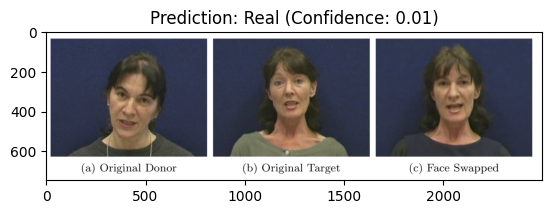

--- Analysis for /content/Deepfakes-detection/processed/images/deepfake_images_2.png ---
Raw Prediction Value: 463
Confidence Score: 0.01
Prediction: Real



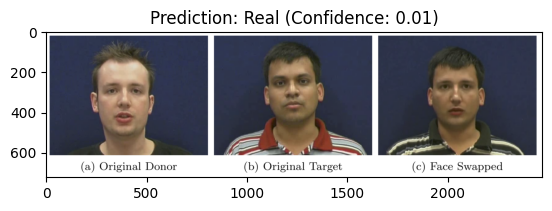

In [ ]:
# Install matplotlib if not already installed
!pip install matplotlib

import torch
import torch.nn.functional as F
import torch_xla.core.xla_model as xm
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt

# Define the image processing function
def process_image(image_path):
    # Define the image transformations
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Function to analyze and make predictions
def analyze_image(model, image_path):
    # Process the image and get the image tensor
    image_tensor = process_image(image_path)

    with torch.no_grad():
        image_tensor = image_tensor.to(xm.xla_device())  # Use TPU device
        outputs = model(image_tensor)

        # Apply softmax to get confidence scores
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        # Get the raw predicted value and confidence
        predicted_class = predicted.item()
        confidence_score = confidence.item()

        # Interpret the prediction as Fake or Real
        prediction = "Fake" if predicted_class == 1 else "Real"

        # Output raw prediction, confidence score, and class interpretation
        output_details = {
            "Image Path": image_path,
            "Raw Prediction Value": predicted_class,
            "Confidence Score": confidence_score,
            "Prediction": prediction
        }

        # Return the details for further processing or output
        return output_details, image_path

# Load a pre-trained model (replace with your own model if needed)
model = models.resnet18(pretrained=True)
model = model.to(xm.xla_device())  # Move the model to TPU device

# Example image paths (processed images only)
image_paths = [
    '/content/Deepfakes-detection/processed/images/deepfake_images_1.png',
    '/content/Deepfakes-detection/processed/images/deepfake_images_2.png'
]

# Analyze each image, output predictions, and display results
for image_path in image_paths:
    try:
        # Analyze the image and get the prediction details
        output_details, image_path = analyze_image(model, image_path)

        # Print the structured output
        print(f"--- Analysis for {output_details['Image Path']} ---")
        print(f"Raw Prediction Value: {output_details['Raw Prediction Value']}")
        print(f"Confidence Score: {output_details['Confidence Score']:.2f}")
        print(f"Prediction: {output_details['Prediction']}\n")

        # Display the image along with the prediction
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(f"Prediction: {output_details['Prediction']} (Confidence: {output_details['Confidence Score']:.2f})")
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")